#### Packages

In [1]:
from libsvm.svmutil import *
from liblinear.liblinearutil import *
from sklearn import linear_model
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import random
import math
import sys

#### Read Data

In [2]:
df_tr = pd.read_csv("ML_FP_train.csv")
df_tr = df_tr.drop(['Album_type', 'Licensed', 'official_video', 'Track', 'Album', \
    'Uri', 'Url_spotify', 'Url_youtube', 'Comments', 'Description', 'Title', \
    'Channel', 'Composer', 'Artist'], axis=1)
df_t = pd.read_csv("ML_FP_test.csv")
df_t = df_t.drop(['Album_type', 'Licensed', 'official_video', 'Track', 'Album', \
    'Uri', 'Url_spotify', 'Url_youtube', 'Comments', 'Description', 'Title', \
    'Channel', 'Composer', 'Artist'], axis=1)

# df_tr.shape (17170, 29)
# random_rows = df_tr.sample(n=10)
# print(random_rows)
print(df_tr.columns)

df_tr = df_tr.fillna(df_tr.median()) #處理缺失值
df_tr = df_tr.astype({"Danceability":"int", "Views":"int", "Likes":"int", "Stream":"int"})
df_t = df_t.fillna(df_t.median()) #處理缺失值
df_t = df_t.astype({"Views":"int", "Likes":"int", "Stream":"int"})

Index(['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Duration_ms', 'Views', 'Likes', 'Stream', 'id'],
      dtype='object')


In [43]:
df_tr.describe()

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Stream,id
count,17170.000000,1.717000e+04,17170.000000,17170.000000,17170.000000,1.717000e+04,17170.000000,17170.000000,17170.000000,17170.000000,1.717000e+04,1.717000e+04,1.717000e+04,1.717000e+04,17170.000000
mean,4.586022,3.298228e-01,5.196506,-7.398377,0.089008,9.865013e-02,0.046612,0.029045,0.526615,120.797212,2.211933e+05,6.497058e+07,5.697116e+05,1.122262e+08,8584.500000
std,2.858980,2.243601e-01,3.185355,4.205446,0.096486,2.078188e-01,0.177396,0.106644,0.225816,27.364553,1.116707e+05,2.092509e+08,1.602239e+06,2.235556e+08,4956.696396
min,0.000000,8.365427e-15,0.000000,-46.251000,0.000000,1.367631e-18,0.000000,0.000003,0.000000,0.000000,3.098500e+04,-2.147484e+09,0.000000e+00,-2.147484e+09,0.000000
25%,2.000000,1.601030e-01,2.000000,-8.124000,0.038000,2.409325e-04,0.000000,0.000982,0.368000,100.071000,1.851942e+05,2.909370e+06,3.334325e+04,1.994607e+07,4292.250000
50%,5.000000,2.954083e-01,5.000000,-6.472000,0.051400,6.967871e-03,0.000002,0.001907,0.531000,119.995500,2.120300e+05,1.427208e+07,1.239210e+05,4.550224e+07,8584.500000
75%,7.000000,4.600996e-01,8.000000,-5.175000,0.089400,6.643013e-02,0.000135,0.008000,0.689000,135.065250,2.403968e+05,4.879191e+07,3.938395e+05,1.007639e+08,12876.750000
max,9.000000,1.000000e+00,10.000000,0.829000,0.964000,9.880479e-01,1.000000,1.000000,0.993000,243.372000,4.581483e+06,2.118025e+09,4.014762e+07,2.136271e+09,17169.000000


##### Levels of Danceability, Barplot

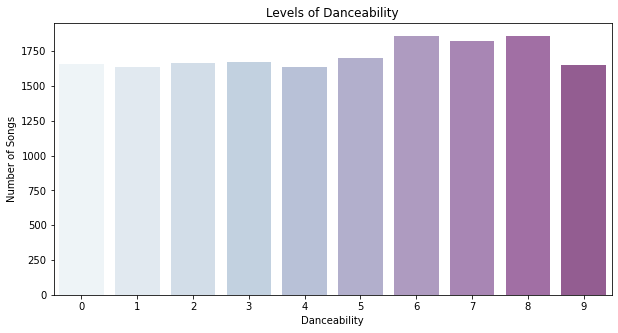

In [51]:
df_tr["Danceability"] = df_tr["Danceability"].astype("category")
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=df_tr, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

df_tr["Danceability"] = df_tr["Danceability"].astype("int")

##### Correlation Matrix, Heatmap

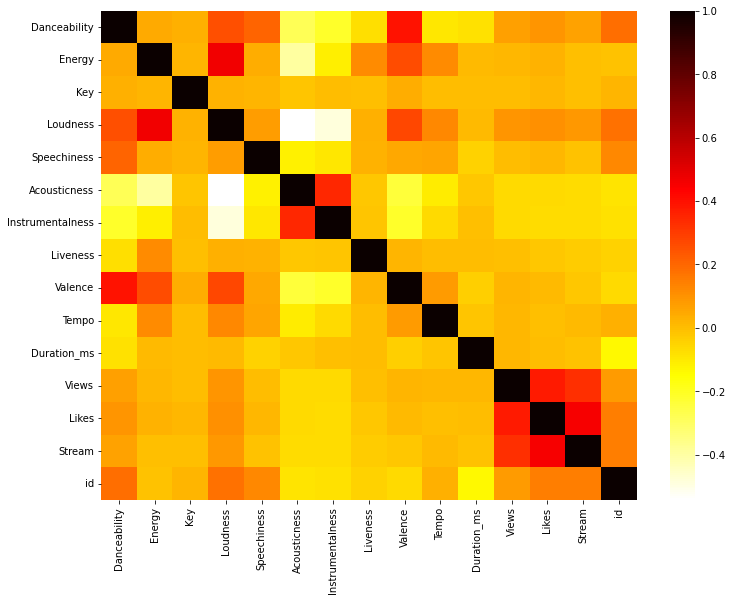

In [57]:
# Heatmap
plt.figure(figsize = (12, 9))
sns.heatmap(df_tr.corr(), cmap = "hot_r")
plt.show()

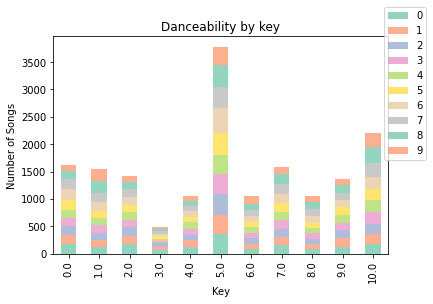

In [74]:
# Danceability by key Visualization
colors = sns.color_palette("Set2")
key = df_tr.groupby(["Key","Danceability"]).Key.count().unstack()
p1 = key.plot(kind = "bar", stacked = True, 
                   title = "Danceability by key", 
                   color = colors, alpha = .70)
p1.set_xlabel("Key")
p1.set_ylabel("Number of Songs")
plt.legend(bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)
plt.show()

### Model

#### OLS

##### OLS, self-choosing

In [95]:
dep_var = 'Danceability'
indep_selfpick_var = ['Key', 'Loudness', 'Speechiness', 'Acousticness', 'Valence']

y_tr = df_tr[dep_var]
X_tr = df_tr[indep_selfpick_var]
X_t = df_t[indep_selfpick_var]

# with statsmodels
X_tr = sm.add_constant(X_tr) # adding a constant
X_t = sm.add_constant(X_t)
ols_model = sm.OLS(y_tr, X_tr).fit()

ols_predictions_t = ols_model.predict(X_t) 
# Round the predicted values to the nearest integer and convert to integers
ols_predictions_t = predictions_t.round().astype(int)
# Map the predicted values to the range {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
ols_predictions_t = predictions_t.clip(0, 9)

print_ols_model = ols_model.summary()
print(print_ols_model)

ols_predictions_df = pd.DataFrame({'id': df_t['id'], 'Danceability': ols_predictions_t})
ols_predictions_df.to_csv('ols_submission.csv', index=False)

                            OLS Regression Results                            
Dep. Variable:           Danceability   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     985.2
Date:                Thu, 18 May 2023   Prob (F-statistic):               0.00
Time:                        17:50:54   Log-Likelihood:                -40233.
No. Observations:               17170   AIC:                         8.048e+04
Df Residuals:                   17164   BIC:                         8.052e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.4525      0.077     31.814   

##### check distribution of danceability

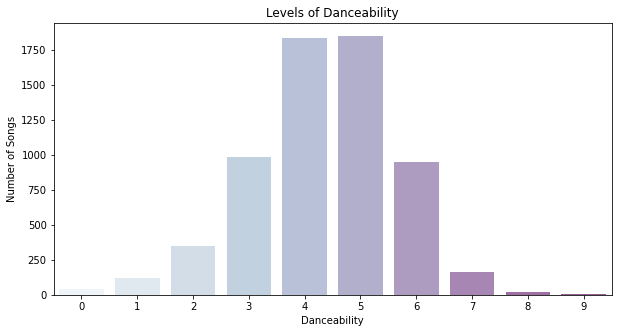

In [93]:
ols_predictions_df["Danceability"] = ols_predictions_df["Danceability"].astype("category")
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=ols_predictions_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

ols_predictions_df["Danceability"] = ols_predictions_df["Danceability"].astype("int")

###### Score: 2.14919

#### SVM

##### C=1

In [3]:
dep_var = 'Danceability'
indep_var = ['Energy', 'Key', 'Loudness', 'Speechiness','Acousticness',\
     'Instrumentalness', 'Liveness', 'Valence', 'Tempo','Duration_ms', 'Views', 'Likes', 'Stream']
y_tr = df_tr[dep_var].values.tolist()
X_tr = df_tr[indep_var].values.tolist()
X_t = df_t[indep_var].values.tolist()


In [3]:
# linear kernel: -t=0
param = f'-s 0 -t 0 -c 1 -q'
hard_svm_model = svm_train(y_tr, X_tr , param)
hard_svm_predictions_t, _, _ = svm_predict([], X_t, hard_svm_model)

hard_svm_predictions_df = pd.DataFrame({'id': df_t['id'], 'Danceability': hard_svm_predictions_t})
hard_svm_predictions_df.to_csv('svm_hard_submission.csv', index=False)

Accuracy = 0.0633413% (4/6315) (classification)


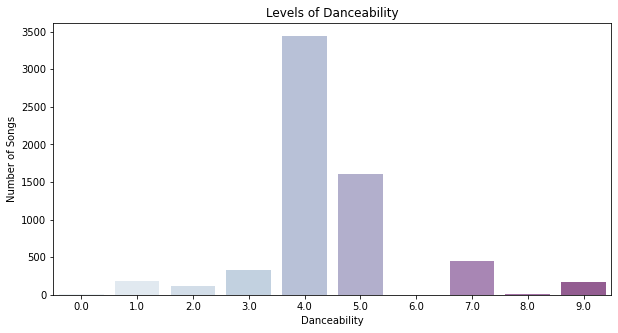

In [4]:
hard_svm_predictions_df["Danceability"] = hard_svm_predictions_df["Danceability"].astype("category")
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=hard_svm_predictions_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()

##### C=0.1

In [4]:
# linear kernel: -t=0
param = f'-s 0 -t 0 -c 1 -q'
soft_svm_model = svm_train(y_tr, X_tr , param)
soft_svm_predictions_t, _, _ = svm_predict([], X_t, soft_svm_model)

soft_svm_predictions_df = pd.DataFrame({'id': df_t['id'], 'Danceability': soft_svm_predictions_t})
soft_svm_predictions_df.to_csv('svm_hard_submission.csv', index=False)

In [ ]:
soft_svm_predictions_df["Danceability"] = soft_svm_predictions_df["Danceability"].astype("category")
# Target Variable Countplot
plt.figure(figsize = (10, 5))
sns.countplot(data=soft_svm_predictions_df, x="Danceability", alpha = .70, palette = "BuPu")
plt.title("Levels of Danceability")
plt.ylabel("Number of Songs")
plt.show()